In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

### Cargamos el dataset

In [73]:
df = pd.read_csv('Data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Eliminamos las columnas que no son predicturas

In [74]:
df = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

Creamos cageogoricas

In [75]:
df = pd.get_dummies(df)
del df['Sex_female']

### Pequeña exploración de datos

In [76]:
df.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,,,,,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887,0.852459,0.136612,0.085610,0.777778
1,1.950292,28.343690,0.473684,0.464912,48.395408,0.318713,0.271930,0.087719,0.634503


Quitamos los NA's

In [77]:
df.isna().mean()

Survived      0.000000
Pclass        0.000000
Age           0.198653
SibSp         0.000000
Parch         0.000000
Fare          0.000000
Sex_male      0.000000
Embarked_C    0.000000
Embarked_Q    0.000000
Embarked_S    0.000000
dtype: float64

In [78]:
df['Age'] = df['Age'].fillna(df.Age.mean())

### Crea un modelo 

In [79]:
target = 'Survived'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = linear_model.LogisticRegression().fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Predicciones del modelo, cuales son los tipos que hay 

In [80]:
probas = model.predict_proba(X_test)

probabilidades = [i[1] for i in probas]
predicciones = model.predict(X_test)

calibracion = pd.DataFrame({
     'target': y_test,
     'probabilidades': probabilidades,
     'predicciones': predicciones
})

### Calibracion

In [81]:
calibracion['bins'] = pd.qcut(calibracion['probabilidades'], q=10, labels=False) + 1
grouped = calibracion.groupby('bins').mean()

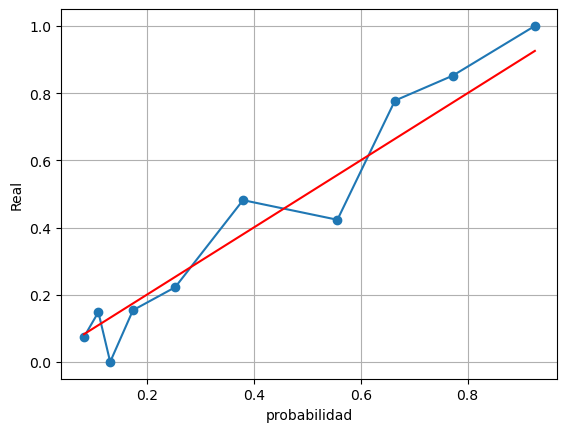

In [82]:
plt.plot(grouped.probabilidades, grouped.target, marker="o")
plt.plot(grouped.probabilidades, grouped.probabilidades, color='r')
plt.xlabel("probabilidad")
plt.ylabel("Real")
plt.grid()

### ¿Qué tanto le atina?

In [83]:
np.mean(calibracion.predicciones == calibracion.target)

0.8134328358208955

Con sklearn 

In [84]:
from sklearn.metrics import accuracy_score

In [85]:
accuracy_score(y_pred=calibracion.predicciones, y_true=calibracion.target)

0.8134328358208955

###  Histogramas 

In [86]:
prob_1 = calibracion.query("target == 1")['probabilidades']
prob_0 = calibracion.query("target == 0")['probabilidades']

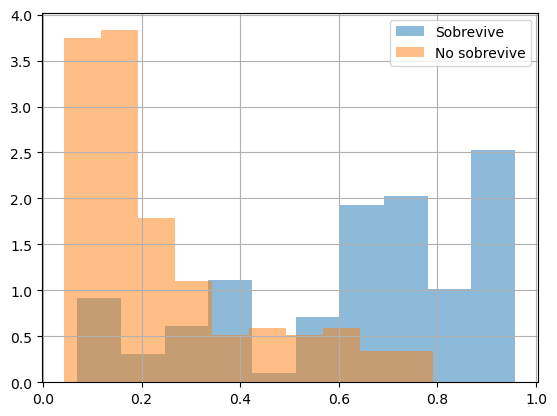

In [87]:
plt.hist(prob_1, alpha = 0.5, density=True, label = 'Sobrevive')
plt.hist(prob_0, alpha = 0.5, density=True, label = 'No sobrevive')
plt.legend()
plt.grid()

### Usando statsmodel

In [88]:
import statsmodels.formula.api as smf
df = pd.read_csv('Data/titanic.csv')

In [89]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [90]:
df.keys()

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [97]:
model = smf.logit('Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)', data=df).fit()


Optimization terminated successfully.
         Current function value: 0.444060
         Iterations 6


In [98]:
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,4.4329,0.536,8.271,0.000,3.383,5.483
C(Pclass)[T.2],-1.1896,0.329,-3.614,0.000,-1.835,-0.544
C(Pclass)[T.3],-2.3952,0.343,-6.976,0.000,-3.068,-1.722
C(Sex)[T.male],-2.6379,0.223,-11.829,0.000,-3.075,-2.201
C(Embarked)[T.Q],-0.8234,0.600,-1.372,0.170,-2.000,0.353
C(Embarked)[T.S],-0.4028,0.275,-1.467,0.142,-0.941,0.135
Age,-0.0433,0.008,-5.204,0.000,-0.060,-0.027
SibSp,-0.3629,0.129,-2.807,0.005,-0.616,-0.110
Parch,-0.0604,0.124,-0.487,0.626,-0.303,0.183
Fare,0.0015,0.003,0.559,0.576,-0.004,0.007
